# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

<b>Tasks:</b>
* Predict churn of customers
* Predict likelihood to upgrade
* Predict the lifetime value of the customer based on the above

In [84]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

#hyperopt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import sklearn.metrics
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.listdir()

['README.md',
 'mini_sparkify_event_data.json',
 'Sparkify.ipynb',
 '.gitignore',
 '.ipynb_checkpoints',
 '.git',
 'EDA_report.html']

In [53]:
def load_user_data():
    df = pd.read_json('mini_sparkify_event_data.json',lines=True)
    # convert column names to lowercase
    df.columns = [col.lower() for col in df.columns]
    # remove rows not connected to any users
    df = df.loc[df['userid'].notna()]
    # Remove empty user id records.
    df = df[~(df['userid']=="")]
    return df
    
def generate_eda_report(df, report_name):
    # generate EDA report if it doesen't exist
    if os.path.exists(f'./{report_name}'):
        print("EDA report already in the folder.")
    else:
        print("Generating EDA report...")
        profile = ProfileReport(df, title="Pandas Profiling Report")
        profile.to_file(report_name)
        print("EDA report saved.")

def convert_dates(df,date_columns):
    for col in date_columns:
        df[col] = pd.to_datetime(df[col],unit='ms')
        
def get_dates_range(df):
    date_min = df['ts'].min()
    date_max = df['ts'].max()
    return date_min, date_max

def add_interaction_features(df):
    """
    Prefered this function over one hot encoding to avoid adding useless features and possible data leakage
    """
    df['song_played'] = df['page'] == 'NextSong'
    df['add_playlist'] = df['page'] == 'Add to Playlist'
    df['thumbed_up'] = df['page'] == 'Thumbs Up'
    df['thumbed_down'] = df['page'] == 'Thumbs Down'
    df['added_friend'] = df['page'] == 'Add Friend'
    df['once_premium'] = df['level'] == 'paid'
    # Target variable. Note that cancellation refers to premium and free accounts.
    df['cancelled'] = df['page'] == 'Cancellation Confirmation'
    df['redirected'] = df['status']==307
    df['error'] = df['status']==404
    
    
def add_user_features(df): 
    users = df.groupby('userid').agg(
    {'userid': [('user_id','max')],
     'page': [('page_count', 'count')], 
     'registration': [('registration_date','max')],
     'ts': [('last_interaction','max')],
     'song_played': [('songs_played', 'sum')],
     'add_playlist': [('songs_playlisted', 'sum')],
     'thumbed_up': [('thumbed_up', 'sum')],
     'thumbed_down': [('thumbed_down', 'sum')],
     'added_friend': [('added_friends', 'sum')],
     'cancelled': [('cancelled', 'max')], 
     'once_premium': [('once_premium', 'max')],
     'location': [('top_location', pd.Series.mode)],
     'gender': [('user_gender',pd.Series.mode)],
     'error': [('error_count', 'count')],
     'redirected': [('redirect_count', 'count')]
    })
    
    users.columns = users.columns.droplevel()
    users = users.reset_index(drop=True)
    #users['last_interaction'] = pd.to_datetime(users['last_interaction'], errors='coerce')
    #users['registration_date'] = pd.to_datetime(users['registration_date'], errors='coerce')
    users['days_active'] = (users['last_interaction'] - users['registration_date']).dt.days
    users["cancelled"] = users["cancelled"].astype(int)
    users["once_premium"] = users["once_premium"].astype(int)
    return users

def add_session_features(df):
    sessions = df.groupby(['userid','sessionid'],as_index=False).agg(
    {'ts': [np.min,np.max]
    })
    sessions.columns = ['userid','sessionid','tmin','tmax']
    sessions['session_length'] = sessions['tmax']-sessions['tmin']
    sessions['time_minutes'] = sessions['session_length'] // np.timedelta64(1, 'm')

    user_sessions = sessions.groupby('userid').agg(
        {'time_minutes': [('time_mean',np.mean)],
         'sessionid': [('session_count', 'count')],
        })

    user_sessions.columns = ['time_mean','session_count']
    user_sessions = user_sessions.reset_index(drop=False)
    user_sessions['time_mean']= user_sessions['time_mean'].astype(int)
    return user_sessions

    
def add_ndays_features(df,n_days): 
    users = df.groupby('userid').agg(
    {'userid': [('user_id','max')],
    'song_played': [(f'{n_days}d_songs_played', 'sum')],
     'add_playlist': [(f'{n_days}d_songs_playlisted', 'sum')],
     'thumbed_up': [(f'{n_days}d_thumbed_up', 'sum')],
     'thumbed_down': [(f'{n_days}d_thumbed_down', 'sum')],
     'added_friend': [(f'{n_days}d_added_friends', 'sum')]
     })
    users.columns = users.columns.droplevel()
    users = users.reset_index(drop=True)
    return users

def add_latest_interaction(df,users):
    # get the last interaction
    user_last_interaction = users[['user_id','last_interaction']]
    df = df.merge(user_last_interaction, left_on='userid', right_on='user_id').drop('user_id',axis=1)
    df['timedelta'] = (df['ts'] - df['last_interaction']).dt.days
    return df

def last_n_days(df,n_days):
    df_filtered = df.loc[df['timedelta']>=(-n_days)]
    df_filtered = add_ndays_features(df_filtered ,n_days)
    return df_filtered

def merge_ndays_features(users_table, feat_tables):
    for table in feat_tables:
        users_table = users_table.merge(table, left_on='user_id', right_on='user_id',
                         how='left', suffixes=('', '_y'))
        users_table.drop(users_table.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
    return users_table

def hyperopt_tuning(X,y):
    def objective(params):
        params = {
            'max_depth': int(params['max_depth']),
            'gamma': "{:.3f}".format(params['gamma']),
            'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        }

        clf = xgb.XGBClassifier(
            n_estimators=500,
            learning_rate = 0.05,
            n_jobs=4,
            **params
        )

        score = cross_val_score(clf, X, y, scoring="roc_auc", cv=StratifiedKFold()).mean()
        print("Score: {:.3f} params {}".format(score, params))
        return score

    space = {
        'max_depth': hp.quniform('max_depth', 2, 10, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
        'gamma': hp.uniform('gamma', 0.0, 0.5)
    }

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=10)
    return best

In [54]:
# Load user data
df = load_user_data()

# Save automated EDA report to current directory
generate_eda_report(df,report_name='EDA_report.html')

# Convert unix timestamps to pandas datetime format
convert_dates(df,date_columns=['ts','registration'])

# Drop unncessary columns
df = df.drop(['auth','method','useragent','lastname','firstname','song'], axis=1)

# Get date range of the dataset
date_min, date_max= get_dates_range(df)
print(f"Dataset interactions date range: {date_max-date_min}")

EDA report already in the folder.
Dataset interactions date range: 63 days 01:09:19


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278154 entries, 0 to 286499
Data columns (total 12 columns):
ts               278154 non-null datetime64[ns]
userid           278154 non-null object
sessionid        278154 non-null int64
page             278154 non-null object
status           278154 non-null int64
level            278154 non-null object
iteminsession    278154 non-null int64
location         278154 non-null object
registration     278154 non-null datetime64[ns]
gender           278154 non-null object
artist           228108 non-null object
length           228108 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 27.6+ MB


# Manual EDA

In [6]:
df.head(5)

,ts,userid,sessionid,page,status,level,iteminsession,location,registration,gender,artist,length
0,2018-10-01 00:01:57,30,29,NextSong,200,paid,50,"Bakersfield, CA",2018-09-28 22:22:42,M,Martha Tilston,277.89016
1,2018-10-01 00:03:00,9,8,NextSong,200,free,79,"Boston-Cambridge-Newton, MA-NH",2018-09-30 18:20:30,M,Five Iron Frenzy,236.09424
2,2018-10-01 00:06:34,30,29,NextSong,200,paid,51,"Bakersfield, CA",2018-09-28 22:22:42,M,Adam Lambert,282.82730
3,2018-10-01 00:06:56,9,8,NextSong,200,free,80,"Boston-Cambridge-Newton, MA-NH",2018-09-30 18:20:30,M,Enigma,262.71302
4,2018-10-01 00:11:16,30,29,NextSong,200,paid,52,"Bakersfield, CA",2018-09-28 22:22:42,M,Daft Punk,223.60771


In [7]:
df['status'].value_counts()

200    254718
307     23184
404       252
Name: status, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df['location'] = LE.fit_transform(df['location'])
df['gender'] = LE.fit_transform(df['gender'])
df.head(5)

,ts,userid,sessionid,page,status,level,iteminsession,location,registration,gender,artist,length
0,2018-10-01 00:01:57,30,29,NextSong,200,paid,50,8,2018-09-28 22:22:42,1,Martha Tilston,277.89016
1,2018-10-01 00:03:00,9,8,NextSong,200,free,79,12,2018-09-30 18:20:30,1,Five Iron Frenzy,236.09424
2,2018-10-01 00:06:34,30,29,NextSong,200,paid,51,8,2018-09-28 22:22:42,1,Adam Lambert,282.82730
3,2018-10-01 00:06:56,9,8,NextSong,200,free,80,12,2018-09-30 18:20:30,1,Enigma,262.71302
4,2018-10-01 00:11:16,30,29,NextSong,200,paid,52,8,2018-09-28 22:22:42,1,Daft Punk,223.60771


In [9]:
# list distinct user actions. This is an important column that will be the main source for feature engineering.
df['page'].value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancel                           52
Cancellation Confirmation        52
Name: page, dtype: int64

---
# Feature Engineering ideas:
**activity**
* number of interactions with the platform
* number of songs played
* number of thumbs Up,thumbs down total thumbs up/total songs played
* number of friends added
* number of songs added to a playlist

**time deltas**
* days since registration
* days since last interaction
* dates between registration and last interaction

**session features**
* average session time
* number of sessions

**target feature**
* Cancellation confirmation

In [10]:
# Add features based on 'page' column
add_interaction_features(df)

In [11]:
# Create a new table with features based on aggregated interactions by userid
users = add_user_features(df)

In [12]:
df.dtypes

ts               datetime64[ns]
userid                   object
sessionid                 int64
page                     object
status                    int64
level                    object
iteminsession             int64
location                  int64
registration     datetime64[ns]
gender                    int64
artist                   object
length                  float64
song_played                bool
add_playlist               bool
thumbed_up                 bool
thumbed_down               bool
added_friend               bool
once_premium               bool
cancelled                  bool
redirected                 bool
error                      bool
dtype: object

In [13]:
# Add latest interaction feature
df = add_latest_interaction(df,users)

In [37]:
df.head(3)

,ts,userid,sessionid,page,status,level,iteminsession,location,registration,gender,...,add_playlist,thumbed_up,thumbed_down,added_friend,once_premium,cancelled,redirected,error,last_interaction,timedelta
0,2018-10-01 00:01:57,30,29,NextSong,200,paid,50,8,2018-09-28 22:22:42,1,...,False,False,False,False,True,False,False,False,2018-11-30 23:58:40,-61
1,2018-10-01 00:06:34,30,29,NextSong,200,paid,51,8,2018-09-28 22:22:42,1,...,False,False,False,False,True,False,False,False,2018-11-30 23:58:40,-61
2,2018-10-01 00:11:16,30,29,NextSong,200,paid,52,8,2018-09-28 22:22:42,1,...,False,False,False,False,True,False,False,False,2018-11-30 23:58:40,-61


In [15]:
# Filter interactions for specific timeframe
last_week = last_n_days(df,7)
last_month = last_n_days(df,30)
last_threemonths = last_n_days(df,90)

# Create a list of tables with time related features
feat_tables = [last_week,last_month,last_threemonths]

In [16]:
# Join the time related features with the user table
users = merge_ndays_features(users, feat_tables)

In [38]:
users['playlisted_ratio'] = users['songs_playlisted']/(users['songs_played']+1)
users['thumbed_up_ratio'] = users['thumbed_up']/(users['songs_played']+1)
users['thumbed_down_ratio'] = users['thumbed_down']/(users['songs_played']+1)
users['songs_per_day'] = users['songs_played']/(users['days_active']+1)
users['interactions_per_day'] = users['page_count']/(users['days_active']+1)

In [39]:
users= users.fillna(0)

In [40]:
users.columns

Index(['user_id', 'page_count', 'registration_date', 'last_interaction',
       'songs_played', 'songs_playlisted', 'thumbed_up', 'thumbed_down',
       'added_friends', 'cancelled', 'once_premium', 'top_location',
       'user_gender', 'error_count', 'redirect_count', 'days_active',
       '7d_songs_played', '7d_songs_playlisted', '7d_thumbed_up',
       '7d_thumbed_down', '7d_added_friends', '30d_songs_played',
       '30d_songs_playlisted', '30d_thumbed_up', '30d_thumbed_down',
       '30d_added_friends', '90d_songs_played', '90d_songs_playlisted',
       '90d_thumbed_up', '90d_thumbed_down', '90d_added_friends',
       'playlisted_ratio', 'thumbed_up_ratio', 'thumbed_down_ratio',
       'songs_per_day', 'interactions_per_day', 'userid', 'time_mean',
       'session_count', 'inter_per_session'],
      dtype='object')

In [41]:
session_feat = add_session_features(df)
users = users.merge(session_feat, left_on='user_id', right_on='userid',
                         how='left', suffixes=('', '_y'))

In [42]:
users.columns

Index(['user_id', 'page_count', 'registration_date', 'last_interaction',
       'songs_played', 'songs_playlisted', 'thumbed_up', 'thumbed_down',
       'added_friends', 'cancelled', 'once_premium', 'top_location',
       'user_gender', 'error_count', 'redirect_count', 'days_active',
       '7d_songs_played', '7d_songs_playlisted', '7d_thumbed_up',
       '7d_thumbed_down', '7d_added_friends', '30d_songs_played',
       '30d_songs_playlisted', '30d_thumbed_up', '30d_thumbed_down',
       '30d_added_friends', '90d_songs_played', '90d_songs_playlisted',
       '90d_thumbed_up', '90d_thumbed_down', '90d_added_friends',
       'playlisted_ratio', 'thumbed_up_ratio', 'thumbed_down_ratio',
       'songs_per_day', 'interactions_per_day', 'userid', 'time_mean',
       'session_count', 'inter_per_session', 'userid_y', 'time_mean_y',
       'session_count_y'],
      dtype='object')

In [43]:
users.head()

,user_id,page_count,registration_date,last_interaction,songs_played,songs_playlisted,thumbed_up,thumbed_down,added_friends,cancelled,...,thumbed_down_ratio,songs_per_day,interactions_per_day,userid,time_mean,session_count,inter_per_session,userid_y,time_mean_y,session_count_y
0,10,795,2018-09-28 18:31:35,2018-11-19 12:49:48,673.0,9.0,37.0,4.0,12.0,0,...,0.005935,13.196078,15.288462,10,459,6,132.500000,10,459,6
1,100,3214,2018-09-26 17:17:35,2018-11-30 14:15:49,2682.0,61.0,148.0,27.0,49.0,0,...,0.010063,41.906250,49.446154,100,316,35,91.828571,100,316,35
2,100001,187,2018-08-18 21:24:26,2018-10-02 16:36:45,133.0,3.0,8.0,2.0,2.0,1,...,0.014925,3.022727,4.155556,100001,147,4,46.750000,100001,147,4
3,100002,218,2018-06-25 13:51:29,2018-12-03 01:11:16,195.0,5.0,5.0,0.0,1.0,0,...,0.000000,1.218750,1.354037,100002,200,4,54.500000,100002,200,4
4,100003,78,2018-09-18 22:22:24,2018-10-11 16:19:41,51.0,2.0,3.0,0.0,0.0,1,...,0.000000,2.318182,3.391304,100003,99,2,39.000000,100003,99,2


In [55]:
users['inter_per_session']= users['page_count']/users['session_count']
users['sessions_per_day']= users['session_count']/ users['days_active']

In [92]:
# select relevant columns
users_final = users[['page_count', 'songs_played','songs_playlisted', 'thumbed_up', 'thumbed_down',
       'added_friends','once_premium', 'top_location',
       'user_gender', 'error_count', 'redirect_count', 'days_active',
       '7d_songs_played', '7d_songs_playlisted', '7d_thumbed_up',
       '7d_thumbed_down', '7d_added_friends','playlisted_ratio', 'thumbed_up_ratio', 'thumbed_down_ratio',
       'songs_per_day', 'interactions_per_day','time_mean',
       'session_count','inter_per_session','sessions_per_day', 'cancelled']]

In [93]:
users_final.head(3)

,page_count,songs_played,songs_playlisted,thumbed_up,thumbed_down,added_friends,once_premium,top_location,user_gender,error_count,...,playlisted_ratio,thumbed_up_ratio,thumbed_down_ratio,songs_per_day,interactions_per_day,time_mean,session_count,inter_per_session,sessions_per_day,cancelled
0,795,673.0,9.0,37.0,4.0,12.0,1,51,1,795,...,0.013353,0.054896,0.005935,13.196078,15.288462,459,6,132.500000,0.117647,0
1,3214,2682.0,61.0,148.0,27.0,49.0,1,26,1,3214,...,0.022736,0.055162,0.010063,41.906250,49.446154,316,35,91.828571,0.546875,0
2,187,133.0,3.0,8.0,2.0,2.0,0,61,0,187,...,0.022388,0.059701,0.014925,3.022727,4.155556,147,4,46.750000,0.090909,1


In [94]:
y = users_final['cancelled']
X = users_final.drop('cancelled',axis=1)

X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(X, y, random_state=1)

In [96]:
users_final['cancelled'].value_counts()

0    173
1     52
Name: cancelled, dtype: int64

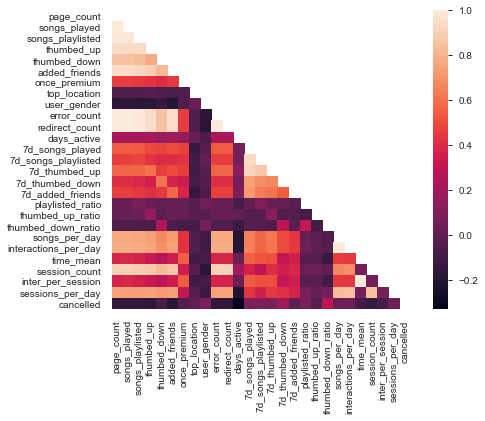

In [122]:
corr = users_final.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(correlations, mask=mask, square=True)


In [ ]:
pp = sns.pairplot(data=users_final,
                  y_vars=['cancelled'],
                  x_vars=['songs_played'])

In [50]:
best = hyperopt_tuning(X,y)
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.9099384703080164, 'gamma': 0.07420681887516273, 'max_depth': 5.0}


In [117]:
# Instantiate the model
xgb_model = xgb.XGBClassifier(learning_rate=0.05, 
              max_depth=12, colsample_bytree=0.9, 
              gamma=0.10,
              n_estimators=250,           
              objective='binary:logistic', 
              random_state=42)

# fit model to training data
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        44
           1       0.75      0.46      0.57        13

    accuracy                           0.84        57
   macro avg       0.80      0.71      0.74        57
weighted avg       0.83      0.84      0.83        57



In [118]:
# Instantiate the model
xgb_model = xgb.XGBClassifier(booster='dart',parameters=best,learning_rate=0.05, 
              n_estimators=250,           
              objective='binary:logistic', 
              random_state=42)

# fit model to training data
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89        44
           1       0.67      0.46      0.55        13

    accuracy                           0.82        57
   macro avg       0.76      0.70      0.72        57
weighted avg       0.81      0.82      0.81        57



In [32]:
importance = xgb_model.get_booster().get_score(importance_type= 'gain')
sorted(importance.items(), key=lambda x:x[1],reverse=True)

[('days_active', 1.6863317374103879),
 ('thumbed_down_ratio', 1.3432861610164832),
 ('thumbed_up', 1.1674429544787877),
 ('songs_per_day', 1.120277652853725),
 ('7d_songs_playlisted', 1.0425836973464628),
 ('playlisted_ratio', 0.9652895573723534),
 ('thumbed_down', 0.9537660109473686),
 ('7d_thumbed_down', 0.8641763619882352),
 ('time_mean', 0.8489970367272728),
 ('songs_playlisted', 0.8092332260264149),
 ('7d_thumbed_up', 0.7932030954248575),
 ('thumbed_up_ratio', 0.7186950226885248),
 ('interactions_per_day', 0.5497467468333334),
 ('added_friends', 0.5431956099999999),
 ('7d_songs_played', 0.4407484328584905),
 ('page_count', 0.3981722289038461),
 ('user_gender', 0.39477059563157896),
 ('7d_added_friends', 0.3906536781421247),
 ('top_location', 0.3627061883607596),
 ('session_count', 0.34046815095999994),
 ('inter_per_session', 0.31440710705999997),
 ('songs_played', 0.075044306)]

In [119]:
plot_importance(xgb)
plt.show()

NameError: name 'plot_importance' is not defined

In [33]:


clf = RandomForestClassifier(n_estimators=100,random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

0.7719298245614035

In [34]:
X

,page_count,songs_played,songs_playlisted,thumbed_up,thumbed_down,added_friends,once_premium,top_location,user_gender,error_count,...,7d_thumbed_down,7d_added_friends,playlisted_ratio,thumbed_up_ratio,thumbed_down_ratio,songs_per_day,interactions_per_day,time_mean,session_count,inter_per_session
0,795,673.0,9.0,37.0,4.0,12.0,1,51,1,795,...,0.0,2.0,0.013353,0.054896,0.005935,12.942308,15.288462,459,6,132.500000
1,3214,2682.0,61.0,148.0,27.0,49.0,1,26,1,3214,...,4.0,4.0,0.022736,0.055162,0.010063,41.261538,49.446154,316,35,91.828571
2,187,133.0,3.0,8.0,2.0,2.0,0,61,0,187,...,2.0,2.0,0.022388,0.059701,0.014925,2.955556,4.155556,147,4,46.750000
3,218,195.0,5.0,5.0,0.0,1.0,1,96,0,218,...,0.0,0.0,0.025510,0.025510,0.000000,1.211180,1.354037,200,4,54.500000
4,78,51.0,2.0,3.0,0.0,0.0,0,61,0,78,...,0.0,0.0,0.038462,0.057692,0.000000,2.217391,3.391304,99,2,39.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2091,1694.0,46.0,91.0,25.0,32.0,1,79,0,2091,...,0.0,0.0,0.027139,0.053687,0.014749,26.888889,33.190476,211,33,63.363636
221,2176,1802.0,52.0,92.0,24.0,40.0,1,6,0,2176,...,7.0,13.0,0.028841,0.051026,0.013311,24.351351,29.405405,391,19,114.526316
222,2404,1975.0,61.0,108.0,12.0,32.0,1,88,0,2404,...,2.0,3.0,0.030870,0.054656,0.006073,22.443182,27.318182,267,30,80.133333
223,2891,2401.0,58.0,115.0,22.0,45.0,1,41,1,2891,...,2.0,5.0,0.024147,0.047877,0.009159,37.515625,45.171875,370,28,103.250000


In [35]:

print('True values:')
print(np.array(y_test))
print()
print('Predicted:')
print(np.array(y_pred))

True values:
[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0]

Predicted:
[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0]


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [36]:
# create a Spark session